# Model Handler

ModelHandler is a utility class for manipulating and inspecting MXNet models. It can be used to:

* Add and remove layers from an existing model or "freeze" selected layers
* Discover information such as layer names and types
* Extract features from pretrained models

In this tutorial, we will demonstrate some of the key capabilities of ModelHandler.

## Initialisation

In [1]:
import mxnet as mx
import logging

import xfer

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
# Download vgg19 (trained on imagenet)
path = 'http://data.mxnet.io/models/imagenet/'
[mx.test_utils.download(path+'vgg/vgg19-0000.params'),
mx.test_utils.download(path+'vgg/vgg19-symbol.json')]

INFO:root:vgg19-0000.params exists, skipping download
INFO:root:vgg19-symbol.json exists, skipping download


['vgg19-0000.params', 'vgg19-symbol.json']

In [3]:
source_model = mx.module.Module.load('vgg19', 0, label_names=['prob_label'])

# The ModelHandler constructor takes an MXNet Module as input
mh = xfer.model_handler.ModelHandler(source_model)

## Model Inspection

### Layer names

In [4]:
print(mh.layer_names)

['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5', 'flatten_0', 'fc6', 'relu6', 'drop6', 'fc7', 'relu7', 'drop7', 'fc8', 'prob']


### Layer Types
Given the name of a layer, this function returns the type.

In [5]:
print(mh.get_layer_type('relu5_2'))
print(mh.get_layer_type('flatten_0'))
print(mh.get_layer_type('fc7'))
print(mh.get_layer_type('conv5_3'))
print(mh.get_layer_type('prob'))

Activation
Flatten
FullyConnected
Convolution
SoftmaxOutput


ModelHandler can be used to get a list of layers that are of a specific type.

In [6]:
import xfer.model_handler.consts as consts

print(mh.get_layer_names_matching_type(consts.LayerType.CONVOLUTION))
print(mh.get_layer_names_matching_type(consts.LayerType.POOLING))
print(mh.get_layer_names_matching_type(consts.LayerType.ACTIVATION))
print(mh.get_layer_names_matching_type(consts.LayerType.BATCHNORM))

['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4', 'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4']
['pool1', 'pool2', 'pool3', 'pool4', 'pool5']
['relu1_1', 'relu1_2', 'relu2_1', 'relu2_2', 'relu3_1', 'relu3_2', 'relu3_3', 'relu3_4', 'relu4_1', 'relu4_2', 'relu4_3', 'relu4_4', 'relu5_1', 'relu5_2', 'relu5_3', 'relu5_4', 'relu6', 'relu7']
[]


### Architecture Visualization

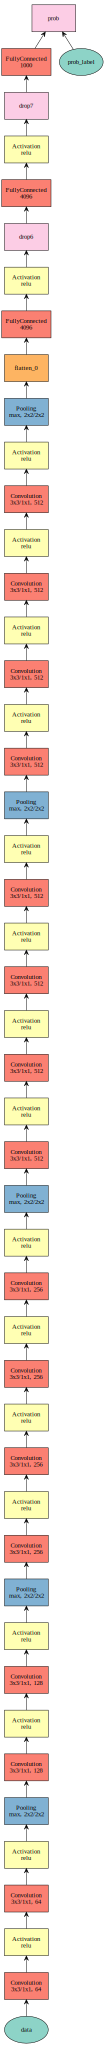

In [7]:
mh.visualize_net()

## Feature Extraction

ModelHandler makes it easy to extract features from a dataset using a pretrained model.

By passing an MXNet DataIterator and a list of the layers to extract features from the `get_layer_output()` method will return a feature dictionary and an ordered list of labels.

In [8]:
imglist = [[0, 'test_images/accordion/accordion_1.jpg'], [0, 'test_images/accordion/accordion_2.jpg'], [0, 'test_images/accordion/accordion_3.jpg'],
           [0, 'test_images/accordion/accordion_4.jpg'], [0, 'test_images/accordion/accordion_5.jpg'], [1, 'test_images/ant/ant_1.jpg'],
           [1, 'test_images/ant/ant_2.jpg'], [1, 'test_images/ant/ant_3.jpg'], [1, 'test_images/ant/ant_4.jpg'], [1, 'test_images/ant/ant_5.jpg'],
           [2, 'test_images/anchor/anchor_1.jpg'], [2, 'test_images/anchor/anchor_2.jpg'], [2, 'test_images/anchor/anchor_3.jpg'],
           [2, 'test_images/anchor/anchor_4.jpg'], [2, 'test_images/anchor/anchor_5.jpg'], [3, 'test_images/airplanes/airplanes_1.jpg'],
           [3, 'test_images/airplanes/airplanes_2.jpg'], [3, 'test_images/airplanes/airplanes_3.jpg'], [3, 'test_images/airplanes/airplanes_4.jpg'],
           [3, 'test_images/airplanes/airplanes_5.jpg']]
iterator = mx.img.ImageIter(imglist=imglist, batch_size=4, path_root='', data_shape=(3, 224, 224))

INFO:root:Using 1 threads for decoding...
INFO:root:Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
INFO:root:ImageIter: loading image list...


In [9]:
features, labels = mh.get_layer_output(data_iterator=iterator, layer_names=['fc6', 'fc8'])

print('Shape of output from fc6:', features['fc6'].shape)
print('Shape of output from fc8:', features['fc8'].shape)
print('Labels:', labels)

print('Subset of example feature:', features['fc8'][0,:100])

INFO:root:Extracting features from layers: fc6 fc8
INFO:root:Processed batch 1
INFO:root:Processed batch 2
INFO:root:Processed batch 3
INFO:root:Processed batch 4
INFO:root:Processed batch 5


Shape of output from fc6: (20, 4096)
Shape of output from fc8: (20, 1000)
Labels: [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]
Subset of example feature: [-2.51732183 -3.06066084 -0.18566455 -1.19558406 -1.65611565 -0.34664321
 -0.27523482 -3.08337784 -3.98712206 -4.7118578  -2.59341359 -1.18219841
  0.06423883 -3.54034257  0.36486915 -2.05150914 -3.36513567  0.47566187
 -0.93592185 -0.53005326 -2.77077436 -1.26748168 -2.32023525 -0.33125317
 -1.5847255  -4.24905443 -4.21701527 -5.69991827 -2.66532969 -3.48009276
 -4.69399214 -3.41049337 -3.673527   -4.22249126 -0.29074478 -6.51374483
 -4.49272871 -4.53610945 -2.54962707  2.17039752 -1.31251311 -2.13473248
 -3.76108098 -2.37120819 -3.80520344 -1.62594509 -1.68116999 -1.48151195
 -2.20818138 -1.57317781 -1.28783798  1.23278439 -3.94669342 -3.93851829
 -0.87836707 -2.94897413 -3.4411037  -4.03095722 -1.49679363 -3.71172714
 -2.23970222 -3.32586694 -2.81456518 -0.63274264 -3.26718354 -1.8046627
 -3.04459739 -1.51519322 -2.72353721  6.5550556

These features can be used for training a meta-model or for clustering as shown in this example.

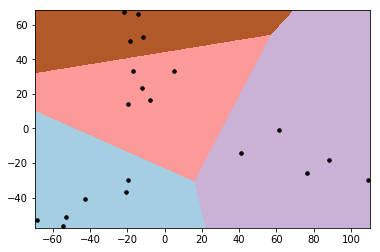

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

reduced_data = PCA(n_components=2).fit_transform(features['fc8'])

kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(reduced_data)

h=0.1

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=7)

## Model Manipulation

Modifying models in MXNet can be problematic because symbols are held as graphs.  This means that modifiying the input of the model requires the graph to be reconstructed above any changes made.  ModelHandler takes care of this for you which means that adding and removing layers from either end of a neural network can be done with 1-2 lines of code.

### Remove layers

In [11]:
# Dropping 4 layers from the top of the layer hierarchy (where top = output)
mh.drop_layer_top(4)
print(mh.layer_names)

INFO:root:relu7, drop7, fc8, prob deleted from model top


['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5', 'flatten_0', 'fc6', 'relu6', 'drop6', 'fc7']


In [12]:
# Dropping a layer from the bottom of the layer hierarchy (where bottom = input)
mh.drop_layer_bottom(1)
print(mh.layer_names)

INFO:root:conv1_1 deleted from model bottom


['relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5', 'flatten_0', 'fc6', 'relu6', 'drop6', 'fc7']


### Add layers

Layers can be added to models by first defining the layer with a LayerFactory object and using the factory to add the layer to the model.

In [13]:
# import model handler's layer factory
import xfer.model_handler.layer_factory as lf

# define LayerFactory objects
fc = lf.FullyConnected(name='fullyconntected1', num_hidden=4)
softmax = lf.SoftmaxOutput(name='softmax')
conv1 = lf.Convolution(name='convolution1', kernel=(20,20), num_filter=64)

# Add layer to the bottom of the layer hierarchy (where bottom = input)
mh.add_layer_bottom([conv1])
# Add layer to the top of the layer hierarchy (where top = output)
mh.add_layer_top([fc, softmax])

print(mh.layer_names)

INFO:root:Added convolution1 to model bottom
INFO:root:Added fullyconntected1, softmax to model top


['convolution1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5', 'flatten_0', 'fc6', 'relu6', 'drop6', 'fc7', 'fullyconntected1', 'softmax']


Once a model has been modified, ModelHandler can be used to return an MXNet Module which can then be used for training.

There is an option to specify parameters which should stay fixed during training or should be randomised before training to allow different modes of transfer learning.

In [14]:
# In this case, the conv1_1 layer will stay fixed during training and the layers fc6 and fc7 will be randomised prior to training
mod = mh.get_module(iterator,
                    fixed_layer_parameters=mh.get_layer_parameters(['conv1_1']),
                    random_layer_parameters=mh.get_layer_parameters(['fc6', 'fc7']))

In [15]:
iterator.reset()
mod.fit(iterator, num_epoch=5)

 /anaconda/envs/xfer_env/lib/python3.5/site-packages/mxnet/module/base_module.py:464: UserWarning:Parameters already initialized and force_init=False. init_params call ignored.
INFO:root:Epoch[0] Train-accuracy=0.100000
INFO:root:Epoch[0] Time cost=42.254
INFO:root:Epoch[1] Train-accuracy=0.250000
INFO:root:Epoch[1] Time cost=39.210
INFO:root:Epoch[2] Train-accuracy=0.250000
INFO:root:Epoch[2] Time cost=40.182
INFO:root:Epoch[3] Train-accuracy=0.250000
INFO:root:Epoch[3] Time cost=38.417
INFO:root:Epoch[4] Train-accuracy=0.250000
INFO:root:Epoch[4] Time cost=39.116


We now have a trained model ready to be used for prediction. This new model isn't very useful but demonstrates the concept - to train a better model, use more data and experiment with combinations of fixed and random layers.

Now you have seen what ModelHandler can do, you should try it out for yourself!

For more details see the [API docs](../api.html#model-handler)